In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Measure Effective Rank and Spectral Norm

In [5]:
M_list = [10,15,20,25,50]
N = 1000 #not used
MAX_CLIQUE_SIZE = 3
NUM_CLIQUES = 3
K = 2
HIGHER_ORDER_CLIQUES = False

spectral_norm = []
effective_rank = []
fred_var_2 = []

for M in M_list:
    print(M)
    
    # Set Graph Structure
    EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
    deps_graph = DependenciesGraph(M, EDGES)

    #Generate Data
    data = DataGenerator(
        N,
        M,
        k=K,
        abstains=False,
        deps_graph=deps_graph,
        class_balance=0.5,
        higher_order_cliques=HIGHER_ORDER_CLIQUES
    )
    sigma_O = data.get_sigma_O()
    
    A = np.hstack((data.get_sigma_O(),data.get_sigma_OH()))
    B = np.hstack((data.get_sigma_OH().T,data.get_sigma_H()))
    sigma_full = np.vstack((A,B))
    sigma_full_inv = np.linalg.inv(sigma_full)

    K_O = sigma_full_inv[0:M,0:M]
    K_OH = sigma_full_inv[-1,0:M]
    K_H = sigma_full_inv[-1,-1]

    Z = np.linalg.inv(K_O)@K_OH.T
    C = 1/(K_H - (K_OH.T@np.linalg.inv(K_O)@K_OH))
    sigma_O_est = np.linalg.inv(K_O) + C*np.outer(Z,Z)

    #Calculate norms
    sn = np.linalg.norm(sigma_O,2)
    spectral_norm.append(sn)
    er = np.trace(sigma_O)/sn
    fred_var_2.append(np.trace(np.linalg.inv(K_O))*sn)

10
15
20
25
50


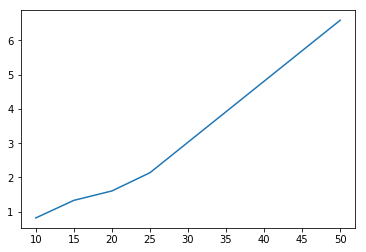

In [6]:
plt.plot(M_list,fred_var_2)

## Fred Bound Sanity Check

In [69]:
# Set Graph Structure
N = 1000 #not used
MAX_CLIQUE_SIZE = 4
NUM_CLIQUES = 3
K = 2
HIGHER_ORDER_CLIQUES = False

M = 15
EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
deps_graph = DependenciesGraph(M, EDGES)

#Generate Data
data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    class_balance=0.5,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
sigma_O = data.get_sigma_O()

In [70]:
A = np.hstack((data.get_sigma_O(),data.get_sigma_OH()))
B = np.hstack((data.get_sigma_OH().T,data.get_sigma_H()))
sigma_full = np.vstack((A,B))
sigma_full_inv = np.linalg.inv(sigma_full)

K_O = sigma_full_inv[0:M,0:M]
K_OH = sigma_full_inv[-1,0:M]
K_H = sigma_full_inv[-1,-1]

Z = np.linalg.inv(K_O)@K_OH.T
C = 1/(K_H - (K_OH.T@np.linalg.inv(K_O)@K_OH))
sigma_O_est = np.linalg.inv(K_O) + C*np.outer(Z,Z)

print("Sanity: ", np.linalg.norm(sigma_O_est - sigma_O))

Sanity:  1.7373028673891137e-16


In [71]:
fred_var = (np.trace(np.linalg.inv(K_O)) - np.trace(C*np.outer(Z,Z)))/np.linalg.norm(sigma_O_est,2)
fred_var

7.216734715385209

In [72]:
sn = np.linalg.norm(sigma_O,2)
er = np.trace(sigma_O)/sn
er

7.416841493138466

In [73]:
fred_bound_numer = np.trace(np.linalg.inv(K_O))+np.linalg.norm(np.sqrt(C)*Z,2)
fred_bound_denom = (1/np.linalg.norm(K_O,2))+np.linalg.norm(np.sqrt(C)*Z,2)
fred_bound_numer/fred_bound_denom

12.61891410270798

In [74]:
(1/np.linalg.norm(K_O,2)) #

0.042948649433967256

In [75]:
1/(MAX_CLIQUE_SIZE**2)

0.0625

In [76]:
np.trace(np.linalg.inv(K_O))*sn

1.0915315248982536

In [77]:
np.sum(np.sort(np.linalg.eigvals(np.linalg.inv(K_O)))[::-1])

2.826040494543973

In [78]:
np.trace(np.linalg.inv(K_O))

2.826040494543969

In [79]:
z = np.array([1,2,3,4,5]);
zzT = np.outer(z,z)
zzT

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10],
       [ 3,  6,  9, 12, 15],
       [ 4,  8, 12, 16, 20],
       [ 5, 10, 15, 20, 25]])

In [80]:
np.sort(np.linalg.eigvals(zzT))[-1] #lambda_max(zzT)

(54.99999999999998+0j)

In [81]:
-np.sort(np.linalg.eigvals(-zzT))[0] #-lambda_min(-zzT)

(54.99999999999998-0j)

In [82]:
np.sort(np.linalg.eigvals(-zzT))[-1] #lambda_max(-zzT)

(7.105427357601002e-15+0j)

## Main Rank Proof

In [83]:
#effective rank of Sigma_O = effective rank of K_O^-1 + (||v||^2/||K_O^-1||)

In [84]:
sn = np.linalg.norm(sigma_O,2)
er = np.trace(sigma_O)/sn

sn_K = np.linalg.norm(np.linalg.inv(K_O),2)
er_K = np.trace(np.linalg.inv(K_O))/sn_K

vvT = sigma_O - np.linalg.inv(K_O)
v = np.linalg.eig(vvT)[1][:,0]

In [87]:
er_K + (np.linalg.norm(v,2)**2/sn_K) - er

3.2506811303391077

In [90]:
np.sort(np.linalg.eigvals(K_O - np.outer(Z,Z)))[0] #lambda_min

2.582400798609136

In [92]:
#lambda_min K_O + lambda_max (-zzT)
np.sort(np.linalg.eigvals(K_O))[0] +  np.sort(np.linalg.eigvals(-np.outer(Z,Z)))[-1] 

(2.7881363615177994+0j)